# 3D (x-y-t) field inference: alpha sensitivity

We start from a flow field generated with `drifter_3D.ipynb` and modify rescale the flow amplitude to change the value of the $\alpha=U\lambda_t/\lambda_s$

In [1]:
import os
from tqdm import tqdm
#import pickle

import numpy as np
import pandas as pd
import xarray as xr
import dask

import matplotlib.pyplot as plt
%matplotlib inline

import corner
import arviz as az

import nwastats as st
colors = st.colors
day = 86400

#data_dir = "data/"
#data_dir = "/home1/scratch/aponte/"
data_dir = "/home/datawork-lops-osi/aponte/nwa/drifter_stats"

In [ ]:
# actually run production inferences
prod=False
overwrite=False
#prod, overwrite = True, True
#prod, overwrite = True, False

local_cluster = not prod
#local_cluster = True # dev
if local_cluster:
    from dask.distributed import Client, LocalCluster
    cluster = LocalCluster()
else:
    from dask.distributed import Client, LocalCluster
    from dask_jobqueue import PBSCluster
    #cluster = PBSCluster(cores=7*2, processes=7*2, walltime="03:00:00")
    cluster = PBSCluster(processes=10, cores=10, walltime="12:00:00")
    # cores=7, processes=7, 02:00:00 by default
    w = cluster.scale(jobs=10)

client = Client(cluster)
client

## Prepare distribution of computations

Computations to be distributed:

- Fixed station inference
- Lagrangian simulation and inference


In [3]:
# flow case
U = "0.1"
#case = "3D_matern32_iso_matern12_pp_r0.0_u"+U
case = "3D_matern52_iso_matern12_pp_r0.0_u"+U
run_dir = os.path.join(data_dir, case)

uv = True # True if u and v are observed
parameter_eta_formulation = False # eta vs nu formulation
noise = 0.01 # observation noise added to u/v
no_time = False # activates time inference
no_space = False
traj_decorrelation = False  # artificially decorrelate different moorings/drifters
enable_nu = False

# number of points used for inference#

# case 1
Nxy, Nt = 1, 50

# case 2
#no_space = True # ! required to be run if time only reference are necessary !

# case 3
#Nxy, Nt = 4, 50
#traj_decorrelation = True  # artificially decorrelate different moorings/drifters

if no_space:
    # makes little sense otherwise
    parameter_eta_formulation = True
    traj_decorrelation = True
assert not no_time, "need to implement decorrelation across time"


# number of ensembles
#Ne = 5 # dev
Ne = 100 # prod

dx = None
#dx = 100. # Nxy>1, separation between platforms

# inference parameters
lowers, uppers = None, None
if enable_nu:
    lowers = [None]*3 + [νs-0.5, νt-0.49] + [None]
    uppers = [None]*3 + [νs+0.5, νt+0.5] + [None]
    #lowers = [None]*3 + [νs-1., νt-0.49] + [None]
    #uppers = [None]*3 + [νs+1., νt+1.] + [None]

# inference parameters
# dsteps = {16: 1/20, 8: 1/20, 4: 1/5, 2: 1/5, 1: 1/2} #v0
dsteps = {16: .05, 8: .1, 4: .15, 2: .2, 1: .3} # v1
if enable_nu:
    dsteps = {k: v*.5 for k, v in dsteps.items()}
s = dsteps[Nxy]
steps = [s]*4
if enable_nu:
    steps = [s]*6

inference_kw = dict(lowers=lowers, uppers=uppers, steps=steps, dx=dx)

### prepare inference

😍AMANDINE👍COLIN🤸🤞🏻

In [4]:
dsf, covfunc, covparams, labels = st.prepare_inference(
    run_dir,
    uv, no_time, no_space,
    parameter_eta_formulation, 
    traj_decorrelation,
    enable_nu,
)
flow_attrs = dict(**dsf.attrs)
truth = {k: v for k, v in zip(labels, [noise]+covparams)}

# flow scales input
#flow_scales = [.5, 1., 2., 3.]
#flow_scales = np.arange(.1, 5., .2)
# np.logspace(-2,np.log10(2), 10)
alpha = np.array([0.01, .05]+list(np.arange(.1, 2., .1)))
flow_scales = alpha*flow_attrs["lambda_x"]*1e3/flow_attrs["U"]/flow_attrs["lambda_t"]/day
print(f"flow_scales = {flow_scales}")
print(f"alpha = {alpha}")

U 0.1
amplitude0 7.745966692414835
amplitude1 0.0
cov_t matern12
cov_x matern52_iso
cov_y matern52_iso
eta 7.745966692414835
kind pp
lambda_t 5
lambda_x 100
lambda_y 100
nu_space 2.5
nu_time 0.5
noise 0.0
pp_ratio 0.0
dx 2.0
dy 2.0
flow_scales = [0.02314815 0.11574074 0.23148148 0.46296296 0.69444444 0.92592593
 1.15740741 1.38888889 1.62037037 1.85185185 2.08333333 2.31481481
 2.5462963  2.77777778 3.00925926 3.24074074 3.47222222 3.7037037
 3.93518519 4.16666667 4.39814815]
alpha = [0.01 0.05 0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1.   1.1  1.2
 1.3  1.4  1.5  1.6  1.7  1.8  1.9 ]


---

## run/load inferences

### mooring inference

In [5]:
def get_file_path_mooring(flow_scale, Nxy, dx, no_space, traj_decorrelation):
    nc = os.path.join(run_dir, f"moorings_fs{flow_scale:.4f}_Nxy{Nxy}.nc")
    if dx is not None:
        nc = nc.replace(".nc", f"_dx{dx:0.0f}.nc")
    if no_space:
        nc = nc.replace(".nc", f"_nospace.nc")
    if traj_decorrelation:
        nc = nc.replace(".nc", f"_trajd.nc")
    if enable_nu:
        nc = nc.replace(".nc", f"_nu.nc")
    return nc

def run_inferences_mooring(flow_scale):

    nc = get_file_path_mooring(flow_scale, Nxy, dx, no_space, traj_decorrelation)

    # note: does not overwrite
    if prod and (not os.path.isfile(nc) or overwrite):
        ds = st.run_mooring_ensembles(
            Ne, dsf, covparams, covfunc, labels, (Nt, Nxy), noise, **inference_kw,
            flow_scale=flow_scale,
        ) 
        ds.to_netcdf(nc, mode="w")
    else:
        ds = xr.open_dataset(nc)
        ds["parameter"] = ds.parameter.astype(str)
        
    return ds

def load_inferences_mooring(no_space):

    Dm = []
    for flow_scale in flow_scales:
        trajd = traj_decorrelation
        if no_space:
            trajd = True
        nc = get_file_path_mooring(flow_scale, Nxy, dx, no_space, trajd)
        ds = xr.open_dataset(nc)
        ds["parameter"] = ds.parameter.astype(str)
        # move noise last
        if no_space:
            ds = ds.sel(parameter=['u', 'λt', 'σ'])
        else:
            ds = ds.sel(parameter=['γ', 'λx', 'λt', 'σ'])
        Dm.append(ds)
        
    return Dm

In [6]:
Dm = []
for f in tqdm(flow_scales):
    Dm.append(run_inferences_mooring(f))

100%|██████████| 21/21 [00:03<00:00,  6.69it/s]


In [7]:
#Dm[0].steps # [6.94444444e-05, 5.37914354e-04, 3.00000000e+01, 1.50000000e+00]


### drifter inference

- Lagrangian simulation
- actual inference


In [8]:
## setup parcels

def run_lagrangian_simulation(flow_scale, overwrite=False):

    import xarray as xr
    from datetime import timedelta
    from parcels import (
        AdvectionRK4,
        FieldSet,
        JITParticle,
        ParticleSet,
        Variable,
    )
        
    # output file
    zarr_file = os.path.join(run_dir, f"drifters_fs{flow_scale:.2f}.zarr")
    if os.path.isdir(zarr_file) and not overwrite:
        return

    #with dask.config.set(scheduler="threads"):    
    # assemble Field set
    flow_file = os.path.join(run_dir, "flow.zarr")
    ds = xr.open_zarr(flow_file, decode_times=False)
    ds["u"] = ds["u"]*flow_scale
    ds["v"] = ds["v"]*flow_scale
    ds["x"] = ds["x"]*1e3 # rescale in m
    ds["y"] = ds["y"]*1e3 # rescale in m
    dx = float(ds["x"][1]-ds["x"][0])
    dy = float(ds["y"][1]-ds["y"][0])
    ds = ds.rename(x="lon", y="lat")
    ds["time"] = ds["time"]*day # rescale in seconds
    ds["time"].attrs.update(units="seconds")

    # define bounds to kill trajectories
    nb = 2
    bounds = (float(ds["lon"].values[0])  + nb*dx,
              float(ds["lon"].values[-1]) - nb*dx,
              float(ds["lat"].values[0])  + nb*dy,
              float(ds["lat"].values[-1]) - nb*dy,
    )

    # generate fieldset
    fieldset = FieldSet.from_xarray_dataset(
        ds,
        variables=dict(U="u", V="v"),
        dimensions=dict(lon="lon", lat="lat", time="time"),                         
        mesh="flat",
    )

    # create Particle set
    di = 5 # subsampling step of input flow grid for parcel seeding position
    _ds = ds.isel(lon=slice(10, -10, di), lat=slice(10, -10, di))    
    #_ds = ds.isel(lon=slice(10,-10,1), lat=slice(10,-10,1)) # coarse grid
    #_ds = ds.isel(lon=slice(10,-10,10), lat=slice(10,-10,10))
    x0 = (_ds.lon   + _ds.lat*0).values.flatten()
    y0 = (_ds.lon*0 + _ds.lat  ).values.flatten()

    pset = ParticleSet.from_list(
        fieldset=fieldset,  # the fields on which the particles are advected
        pclass=JITParticle,  # the type of particles (JITParticle or ScipyParticle)
        lon=x0,  # a vector of release longitudes
        lat=y0,  # a vector of release latitudes
        #time=t0,
    )

    output_file = pset.ParticleFile(
        name=zarr_file,  # the file name
        outputdt=timedelta(hours=1),  # the time step of the outputs
    )

    Tmax = np.floor(float(max(ds["time"]/day)))

    # deal with boundaries
    fieldset.add_constant('b0', bounds[0])
    fieldset.add_constant('b1', bounds[1])
    fieldset.add_constant('b2', bounds[2])
    fieldset.add_constant('b3', bounds[3])
    def StopParticle(particle, fieldset, time):
        # https://github.com/OceanParcels/parcels/blob/bf98c977a260afd86e91ce7af8f3af7dfef90edf/docs/examples/example_stommel.py#L86
        # https://docs.oceanparcels.org/en/latest/reference/particles.html#module-parcels.particle
        #if (particle.lon < bounds[0]) or (particle.lon > bounds[1]) or (particle.lat < bounds[2]) or (particle.lat > bounds[2]):
        if (particle.lon < fieldset.b0) or (particle.lon > fieldset.b1) \
            or (particle.lat < fieldset.b2) or (particle.lat > fieldset.b3):
            particle.delete()
            
    pset.execute(
        AdvectionRK4+pset.Kernel(StopParticle),  # the kernel (which defines how particles move)
        #AdvectionRK4,  # the kernel (which defines how particles move)
        runtime=timedelta(days=Tmax),  # the total length of the run
        dt=timedelta(minutes=30),  # the timestep of the kernel
        #dt=timedelta(minutes=30),  # the timestep of the kernel
        output_file=output_file,
        verbose_progress=False,
    )

    # necessary for older version of parcels (as old as 2.3.0 at least)
    #output_file.export()

#### drifter advection

In [9]:
#Can't distribute parcels simulation for some reason
if prod:
    for f in flow_scales:
        print(f" start {f}")
        run_lagrangian_simulation(f, overwrite=False)
        print(f" end {f}")

#cluster.close()

#### inference

In [10]:
def get_file_path_drifter(flow_scale, Nxy, dx, no_space, traj_decorrelation):
    nc = os.path.join(run_dir, f"drifters_fs{flow_scale:.2f}_Nxy{Nxy}.nc")
    #nc = os.path.join(run_dir, f"drifters_fs{flow_scale:.4f}_Nxy{Nxy}.nc")
    if dx is not None:
        nc = nc.replace(".nc", f"_dx{dx:0.0f}.nc")
    if no_space:
        nc = nc.replace(".nc", f"_nospace.nc")
    if traj_decorrelation:
        nc = nc.replace(".nc", f"_trajd.nc")
    if enable_nu:
        nc = nc.replace(".nc", f"_nu.nc")    
    return nc

def run_inferences_drifter(flow_scale):

    nc = get_file_path_drifter(flow_scale, Nxy, dx, no_space, traj_decorrelation)

    # note: does not overwrite
    if prod and (not os.path.isfile(nc) or overwrite):
        ds = st.run_drifter_ensembles(
            run_dir, Ne, covparams, covfunc, labels, (Nt, Nxy), noise, **inference_kw,
            flow_scale=flow_scale,
        ) 
        ds.to_netcdf(nc, mode="w")
    else:
        ds = xr.open_dataset(nc)
        ds["parameter"] = ds.parameter.astype(str)
        
    return ds

def load_inferences_drifter(no_space):

    Dr = []
    for flow_scale in flow_scales:
        trajd = traj_decorrelation
        if no_space:
            trajd = True
        nc = get_file_path_drifter(flow_scale, Nxy, dx, no_space, trajd)
        ds = xr.open_dataset(nc)
        ds["parameter"] = ds.parameter.astype(str)
        if no_space:
            ds = ds.sel(parameter=['u', 'λt', 'σ'])
        else:
            ds = ds.sel(parameter=['γ', 'λx', 'λt', 'σ'])
        Dr.append(ds)
    
    return Dr

In [11]:
Dr = []
for f in tqdm(flow_scales):
    Dr.append(run_inferences_drifter(f))

100%|██████████| 21/21 [00:02<00:00,  8.06it/s]


---
## concatenate and inspect

In [12]:
if "velocity_deficit" not in flow_attrs:
    flow_attrs["velocity_deficit"] = st.amplitude_decifit(
        flow_attrs["dx"], flow_attrs["lambda_x"], flow_attrs["nu_space"],
    )
    _f = flow_attrs["velocity_deficit"]
    print(f"add velocity_deficit: {_f:.02f}")

add velocity_deficit: 1.00


In [13]:
def _pprocess(ds, λx=None):
    ds = ds.copy()
    for v in ["true_parameters", "flow_scale", "survival_rate", "lower", "upper"]:
        if v in ds:
            ds[v] = ds[v].isel(ensemble=0)
    ds["U"] = float(U) * ds.flow_scale * flow_attrs["velocity_deficit"]
    λt = float(ds["true_parameters"].sel(parameter="λt"))
    if λx is None:
        λx = float(ds["true_parameters"].sel(parameter="λx"))
    ds = (ds
      .assign_coords(α = ds["U"] * λt*day/(λx*1e3))
      .set_coords("true_parameters")
    )
    ds.attrs.update(**flow_attrs)
    if "λx" in ds.parameter.values:
        ds = ds.sel(parameter=['γ', 'λx', 'λt', 'σ'])    
    else:
        ds = ds.sel(parameter=['u', 'λt', 'σ'])
    return ds

dsm = xr.concat([_pprocess(d) for d in Dm], "flow_scale")
dsr = xr.concat([_pprocess(d) for d in Dr], "flow_scale")

/home1/datawork/aponte/miniconda3/envs/nwa/lib/python3.10/site-packages/xarray/core/dataset.py:4744: UserWarning: No index created for dimension flow_scale because variable flow_scale is not a coordinate. To create an index for flow_scale, please first call `.set_coords('flow_scale')` on this object.
  warnings.warn(
/home1/datawork/aponte/miniconda3/envs/nwa/lib/python3.10/site-packages/xarray/core/dataset.py:4744: UserWarning: No index created for dimension flow_scale because variable flow_scale is not a coordinate. To create an index for flow_scale, please first call `.set_coords('flow_scale')` on this object.
  warnings.warn(


In [14]:
# purely temporal inference
Dm_nospace = load_inferences_mooring(True)
Dr_nospace = load_inferences_drifter(True)

dsm_nospace = xr.concat([_pprocess(d, λx=flow_attrs["lambda_x"]) for d in Dm_nospace], "flow_scale")
dsr_nospace = xr.concat([_pprocess(d, λx=flow_attrs["lambda_x"]) for d in Dr_nospace], "flow_scale")

/home1/datawork/aponte/miniconda3/envs/nwa/lib/python3.10/site-packages/xarray/core/dataset.py:4744: UserWarning: No index created for dimension flow_scale because variable flow_scale is not a coordinate. To create an index for flow_scale, please first call `.set_coords('flow_scale')` on this object.
  warnings.warn(
/home1/datawork/aponte/miniconda3/envs/nwa/lib/python3.10/site-packages/xarray/core/dataset.py:4744: UserWarning: No index created for dimension flow_scale because variable flow_scale is not a coordinate. To create an index for flow_scale, please first call `.set_coords('flow_scale')` on this object.
  warnings.warn(


In [15]:
bounds = dict(
    σ=(0.,.1),
    γ=(0.,.35),
    λx=(0,1000),
    λt=(0,20),
)
# common kwargs
kw = dict(x="α", x_off=.055, x_width=0.04, bounds=bounds)

In [16]:
def add_nospace(ds, c, axes, alpha_normalize=False):
    
    for p, k in zip(dsm.parameter.values, axes):
        ax = axes[k]
        if p=="γ":
            da = ds["MAP"].sel(parameter="u").median("ensemble")
            da = np.sqrt( (flow_attrs["nu_space"]-1)/flow_attrs["nu_space"] ) * da
            if alpha_normalize:
                da = (da/da["α"]).rename("γ/α")
            # need to recompose gamma = eta / lambdax = np.sqrt((ν-1)/ν) * U
            ax.plot(da["α"], da, color=c, ls="-")
        if p=="λt":
            da = ds["MAP"].sel(parameter=p) #.median("ensemble")
            #ax.plot(da["α"], da, color=c, ls="--")
            st._shadeplot(ax, da, da["α"], alpha=0.3, color=c)
            ax.plot(da["α"], da.median("ensemble"), color=c, ls="-")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


scp dunree:/home1/datawork/aponte/code/nwastats/notebooks/figs/matern52_iso_alpha_MAP.eps .
scp dunree:/home1/datawork/aponte/code/nwastats/notebooks/figs/matern52_iso_alpha_MAP.png .


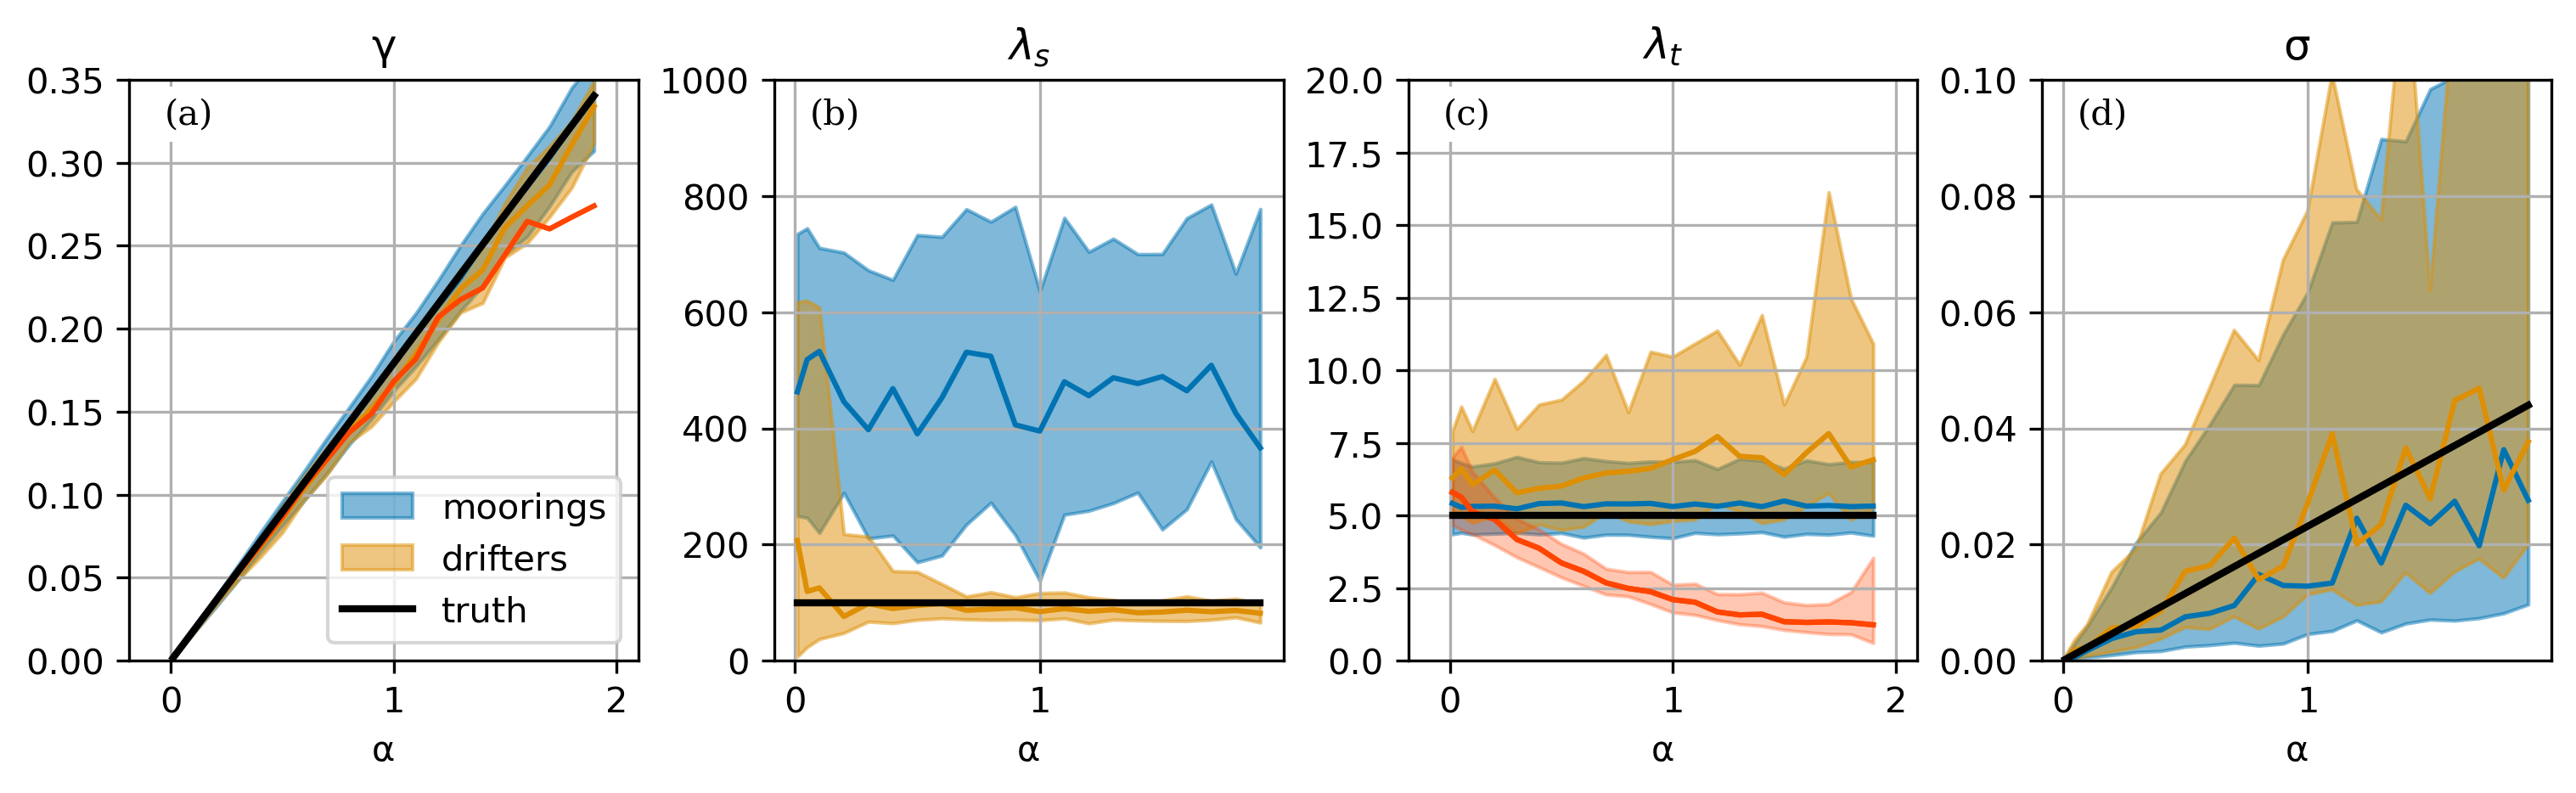

In [41]:
fig, axes = st.plot_sensitivity_combined(
    dsm, dsr, alpha=0.5, legend_loc=0, alpha_normalize=False, **kw,
)

#add_nospace(dsr_nospace, colors["dr"], axes)
#add_nospace(dsm_nospace, colors["mo"], axes)
#add_nospace(dsr_nospace, st.cpal[3], axes)
add_nospace(dsr_nospace, "orangered", axes)

st.label_and_print(fig, axes, flow_attrs["cov_x"]+"_alpha_MAP")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


scp dunree:/home1/datawork/aponte/code/nwastats/notebooks/figs/matern52_iso_alpha_MAP_alphanorm.eps .
scp dunree:/home1/datawork/aponte/code/nwastats/notebooks/figs/matern52_iso_alpha_MAP_alphanorm.png .


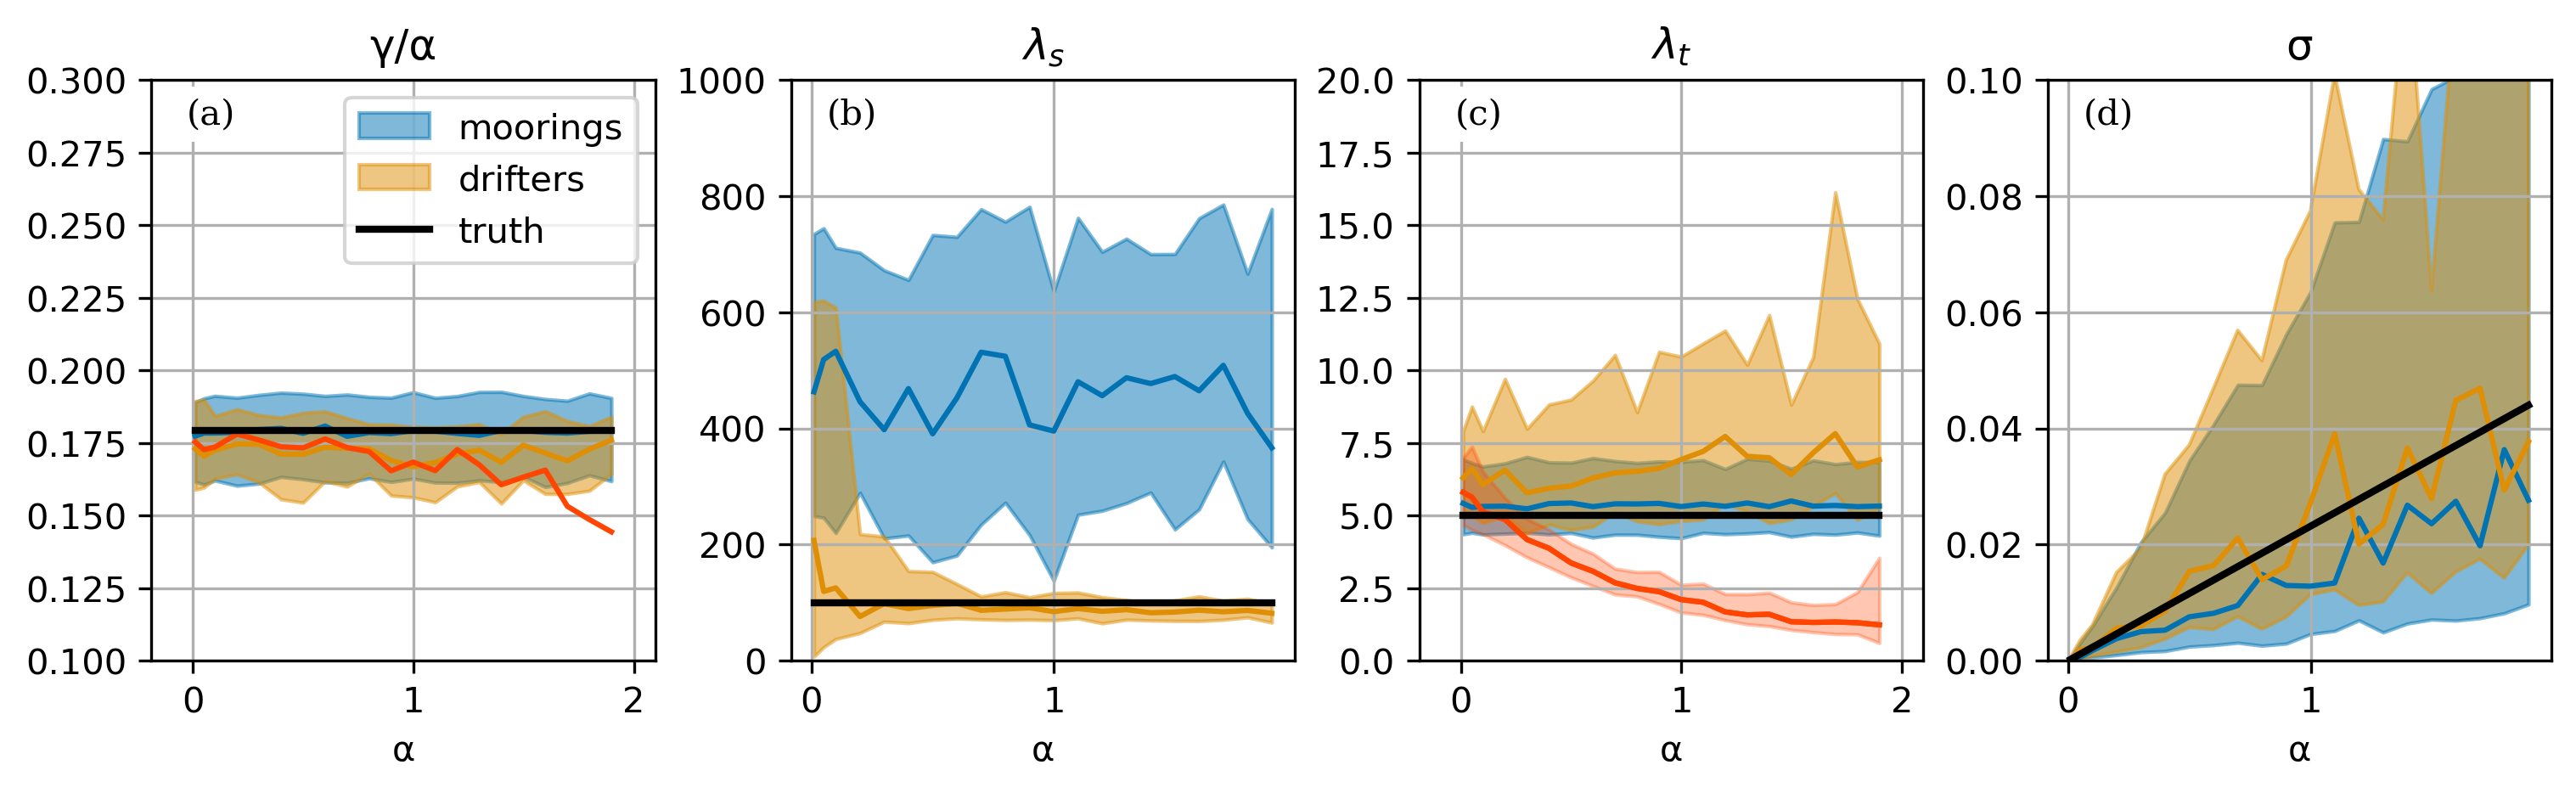

In [42]:
_kw = dict(**kw)
_kw["bounds"]["γ"] = (.1, .3)
fig, axes = st.plot_sensitivity_combined(
    dsm, dsr, alpha=0.5, legend_loc=0, alpha_normalize=True, **_kw,
)

#add_nospace(dsr_nospace, colors["dr"], axes)
#add_nospace(dsm_nospace, colors["mo"], axes)
add_nospace(dsr_nospace, "orangered", axes, alpha_normalize=True)

st.label_and_print(fig, axes, flow_attrs["cov_x"]+"_alpha_MAP_alphanorm")

In [21]:
# print MAP - truth difference along with normalized difference
print("%%% Mooring normalized IQW")
st.print_quantile_width(dsm, "flow_scale")
print("%%% Mooring ratio to truth and normalized difference to truth")
st.print_MAP_truth_difference(dsm, "flow_scale")

%%% Mooring normalized IQW
% flow_scale | γ | λx | λt | σ
% 0.023148148148148147 | 0.15 | 4.86 | 0.52 | 2.19
% 0.11574074074074074 | 0.17 | 4.98 | 0.48 | 2.46
% 0.23148148148148148 | 0.16 | 4.91 | 0.47 | 2.33
% 0.46296296296296297 | 0.17 | 4.14 | 0.48 | 2.52
% 0.6944444444444444 | 0.17 | 4.61 | 0.52 | 2.72
% 0.9259259259259259 | 0.16 | 4.40 | 0.50 | 2.57
% 1.1574074074074074 | 0.16 | 5.63 | 0.48 | 2.76
% 1.3888888888888888 | 0.17 | 5.49 | 0.55 | 2.73
% 1.6203703703703705 | 0.17 | 5.43 | 0.51 | 2.74
% 1.8518518518518519 | 0.16 | 4.84 | 0.49 | 2.42
% 2.0833333333333335 | 0.16 | 5.65 | 0.52 | 2.56
% 2.314814814814815 | 0.17 | 4.98 | 0.53 | 2.54
% 2.5462962962962963 | 0.16 | 5.11 | 0.50 | 2.76
% 2.7777777777777777 | 0.17 | 4.46 | 0.45 | 2.47
% 3.00925925925926 | 0.17 | 4.55 | 0.51 | 2.82
% 3.240740740740741 | 0.17 | 4.10 | 0.49 | 2.56
% 3.4722222222222228 | 0.15 | 4.74 | 0.47 | 2.63
% 3.7037037037037037 | 0.17 | 5.01 | 0.51 | 2.53
% 3.935185185185186 | 0.16 | 4.42 | 0.49 | 2.69
% 4.1666666

In [22]:
# print MAP - truth difference along with normalized difference
print("%%% Drifter normalized IQW")
st.print_quantile_width(dsr, "flow_scale")
print("%%% Drifter ratio to truth and normalized difference to truth")
st.print_MAP_truth_difference(dsr, "flow_scale")

%%% Drifter normalized IQW
% flow_scale | γ | λx | λt | σ
% 0.023148148148148147 | 0.17 | 6.11 | 0.55 | 2.75
% 0.11574074074074074 | 0.17 | 5.96 | 0.75 | 2.80
% 0.23148148148148148 | 0.12 | 5.70 | 0.63 | 2.32
% 0.46296296296296297 | 0.12 | 1.70 | 0.95 | 2.96
% 0.6944444444444444 | 0.13 | 1.46 | 0.72 | 2.45
% 0.9259259259259259 | 0.16 | 0.90 | 0.83 | 3.07
% 1.1574074074074074 | 0.17 | 0.82 | 0.90 | 2.72
% 1.3888888888888888 | 0.13 | 0.59 | 1.01 | 2.99
% 1.6203703703703705 | 0.13 | 0.39 | 1.08 | 3.04
% 1.8518518518518519 | 0.09 | 0.48 | 0.75 | 2.50
% 2.0833333333333335 | 0.14 | 0.39 | 1.19 | 2.95
% 2.314814814814815 | 0.14 | 0.47 | 1.13 | 2.85
% 2.5462962962962963 | 0.14 | 0.44 | 1.21 | 3.48
% 2.7777777777777777 | 0.12 | 0.45 | 1.19 | 2.58
% 3.00925925925926 | 0.11 | 0.34 | 1.01 | 2.18
% 3.240740740740741 | 0.13 | 0.28 | 1.43 | 3.26
% 3.4722222222222228 | 0.12 | 0.35 | 0.79 | 1.50
% 3.7037037037037037 | 0.16 | 0.42 | 1.03 | 2.68
% 3.935185185185186 | 0.14 | 0.33 | 2.07 | 3.60
% 4.1666666

In [1]:
#fig, axes = st.plot_sensitivity_combined(dsm, dsr, type="boxplot", **kw)

In [ ]:
fig, axes = st.plot_sensitivity_combined(
    dsm, None, label="moorings", alpha=0.5, **kw,
)

In [ ]:
fig, axes = st.plot_sensitivity_combined(
    dsr, None, label="drifters", c=colors["dr"], alpha=0.5, **kw,
)

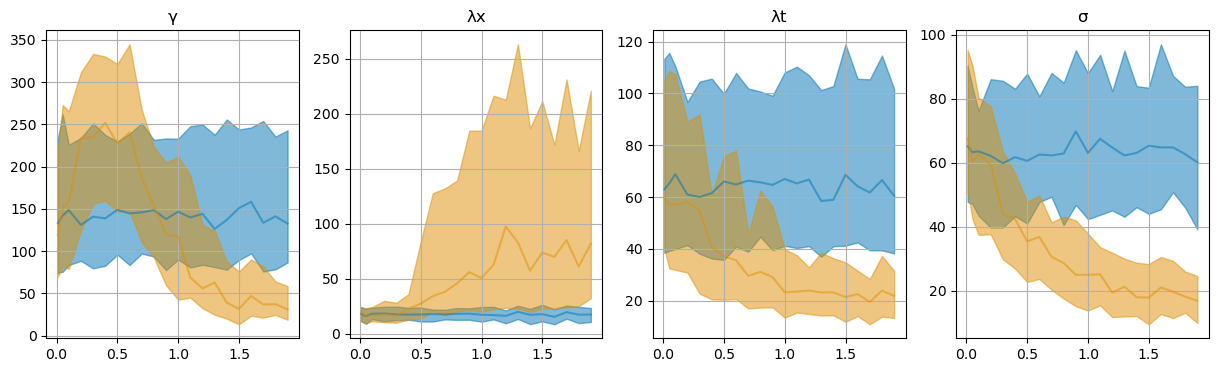

In [43]:
# show ess

def show_variable_parameter(v, dim):

    fig, axes = plt.subplots(1, dsm.parameter.size, figsize=(15,4))
    
    _ds, c = dsm, st.colors["mo"]
    for p, ax in zip(_ds.parameter, axes):
        da = _ds[v].sel(parameter=p).quantile([1/4,1/2,3/4], "ensemble")
        kwargs = dict(color=c, alpha=.5)
        ax.plot(da[dim], da.sel(quantile=1/2), **kwargs)
        h = ax.fill_between(da[dim], da.sel(quantile=1/4), da.sel(quantile=3/4), **kwargs)
        ax.grid()
        ax.set_title(p.data)
    
    _ds, c = dsr, st.colors["dr"]
    for p, ax in zip(_ds.parameter, axes):
        da = _ds[v].sel(parameter=p).quantile([1/4,1/2,3/4], "ensemble")
        kwargs = dict(color=c, alpha=.5)
        ax.plot(da[dim], da.sel(quantile=1/2), **kwargs)
        h = ax.fill_between(da[dim], da.sel(quantile=1/4), da.sel(quantile=3/4), **kwargs)

show_variable_parameter("ess", "α")

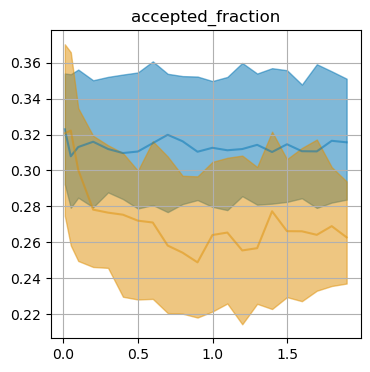

In [44]:

def show_variable_global(v, dim):

    fig, ax = plt.subplots(1, 1, figsize=(4,4))
    
    _ds, c = dsm, st.colors["mo"]
    da = _ds[v].quantile([1/4,1/2,3/4], "ensemble")
    kwargs = dict(color=c, alpha=.5)
    ax.plot(da[dim], da.sel(quantile=1/2), **kwargs)
    h = ax.fill_between(da[dim], da.sel(quantile=1/4), da.sel(quantile=3/4), **kwargs)
    ax.grid()
    ax.set_title(v)
    
    _ds, c = dsr, st.colors["dr"]
    da = _ds[v].quantile([1/4,1/2,3/4], "ensemble")
    kwargs = dict(color=c, alpha=.5)
    ax.plot(da[dim], da.sel(quantile=1/2), **kwargs)
    h = ax.fill_between(da[dim], da.sel(quantile=1/4), da.sel(quantile=3/4), **kwargs)

show_variable_global("accepted_fraction", "α")

---
## survival rate

[99.97829861  5.05642361]


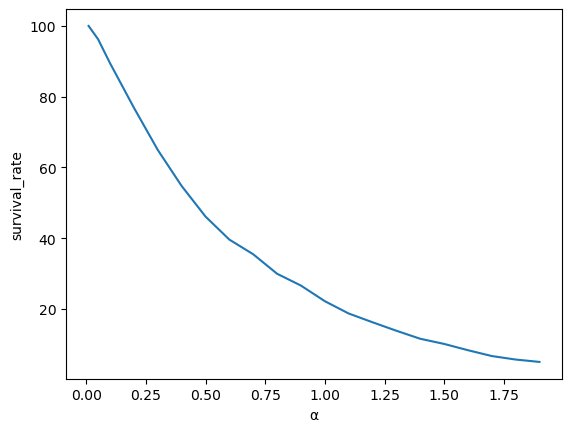

In [45]:
#fig, ax = plt.subplots(1,1)
dsr["survival_rate"].plot(x="α")
#ax.grid()

print(dsr["survival_rate"].isel(flow_scale=[0,-1]).values)

----

In [11]:
cluster.close()